In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
import geopandas as gpd
import xarray as xr
import rioxarray
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import matplotlib as mpl
import cartopy.feature as cf
import regionmask

In [2]:
folder_ts = r'Data\Datasets\amz\ts'
datasets = ['cru', 'gpcc', 'chirps','imerg', 'terra', 'era_land', 'jra55','merra2']
datasets_names = ['CRU', 'GPCC', 'CHIRPS','IMERG-V6', 'TerraClimate', 'ERA5-Land', 'JRA55','MERRA2']
regions = gpd.read_file(r'Data\shapefiles\ANA_amz.geojson', driver='GeoJSON')
regions_mask = regionmask.from_geopandas(regions, names='Region')

In [3]:
from matplotlib.lines import Line2D
plt.rcParams.update({'font.size': 18})
regions_list = ['Western', 'Northern', 'Southern', 'Eastern']
regions_replace = { 0:'Southern', 1:'Eastern',2:'Western', 3:'Northern'}
wong = ['#882255','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7','#999999']
wong_b = ['#882255','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7','#000000']
hue_order = datasets_names.copy()
hue_order.append('Stations')
legend_elements = [Line2D([0], [0],  marker='s', color='w', label=hue_order[i], markerfacecolor=wong[i], markersize=12) for i in range(len(wong))]
legend_elements_b = [Line2D([0], [0],  marker='s', color='w', label=hue_order[i], markerfacecolor=wong_b[i], markersize=12) for i in range(len(wong_b))]


In [4]:
ds_dict = {}
for i, dataset in enumerate(datasets):
    ds = xr.open_dataset(os.path.join(folder_ts, dataset + '.nc'))
    mask = regions_mask.mask(ds, lon_name='lon', lat_name='lat')
    ds = ds.groupby('time.month').mean('time')
    ds['Region'] = mask
    #ds = ds.groupby('region').mean()
    ds_dict[datasets_names[i]] = ds

c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry
c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry


In [5]:
stations = gpd.read_file(r'Data\Evaluation\stations_amz_ANA.geojson')
df_stat= pd.read_pickle(r'Data\Evaluation\amz_01_20_20bet.pkl')
df_month = df_stat.groupby(['Code',df_stat.Date.dt.month]).mean().reset_index()
df_month = df_month.merge(stations[['Code','Region','geometry']], on='Code').drop('Code', axis=1)
#df_month = df_month.groupby(['Region','Date']).mean().reset_index().drop('Code', axis=1)
df_month.rename(columns={'Date':'month', 'Total':'pr'}, inplace=True)
df_month['Dataset'] = 'Stations'

#df = df.append(df_month)

C:\Users\luisg\AppData\Local\Temp\ipykernel_22684\2861186885.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_month = df_stat.groupby(['Code',df_stat.Date.dt.month]).mean().reset_index()


In [6]:
data = df_month[['geometry',  'month','pr']].copy()
data['lon'] = data['geometry'].apply(lambda p: p.x)
data['lat'] = data['geometry'].apply(lambda p: p.y)
data = data.drop(columns=['geometry'])
var = 'pr'

In [7]:
pixel_dict = {}
for i , name in enumerate(datasets_names):
    ds = ds_dict[name].copy()
    
    # Step 2: Assign each point to the grid cells of the 'ds' DataArray
    ds_grid_lon, ds_grid_lat = ds.lon.values, ds.lat.values
    data['lon_bin'] = np.digitize(data['lon'], ds_grid_lon)
    data['lat_bin'] = np.digitize(data['lat'], ds_grid_lat)
    # Step 3: Compute the mean rainfall value for each grid cell and each year
    grid_cells = data.groupby(['lat_bin', 'lon_bin','month'])[var].mean().reset_index()
    # Step 4: Create an empty DataArray with NaN values
    empty_grid = np.full((12, len(ds_grid_lat), len(ds_grid_lon)), np.nan)
    # Step 5: Fill the DataArray with the computed mean rainfall values for each year
    for _, row in grid_cells.iterrows():
        month_idx = np.where(data['month'].unique() == row['month'])[0][0]
        #year_idx = np.where(data['year'].unique() == row['year'])[0][0]
        lat_idx, lon_idx = row['lat_bin'], row['lon_bin']
        #idx to int
        lat_idx, lon_idx = int(lat_idx), int(lon_idx)
        empty_grid[month_idx,  lat_idx - 1, lon_idx - 1] = row['pr']
    # Step 6: Create an xarray DataArray from the result with the year dimension
    month_coords = data['month'].unique()
    #year_coords = data['year'].unique()
    data_array = xr.DataArray(empty_grid,
                                dims=('month', 'lat', 'lon'),
                                coords={'month':month_coords, 'lat': ds_grid_lat, 'lon': ds_grid_lon})
    
    # Now you have an xarray DataArray 'data_array' with the grid of 'ds', mean rainfall values for each cell,
    data_array = data_array.to_dataset(name=var)
    data_array['Region'] = ds['Region']
    pixel_dict[name] = ds.where(data_array.pr >= 0)


In [13]:
#create a df with all ds in ds_dict
df = pd.DataFrame()
for name in datasets_names:
    dff =  pixel_dict[name].to_dataframe().dropna().reset_index()
    dff['Dataset'] = name
    df = df.append(dff)
df = df[['month','pr', 'Region', 'Dataset']]
df['Region'] = df['Region'].replace({ 0:'Southern', 1:'Eastern',2:'Western', 3:'Northern'})
stations = gpd.read_file(r'Data\Evaluation\stations_amz_ANA.geojson')
df_stat= pd.read_pickle(r'Data\Evaluation\amz_01_20_20bet.pkl')
df_month = df_stat.groupby(['Code',df_stat.Date.dt.month]).mean().reset_index()
df_month = df_month.merge(stations[['Code','Region']], on='Code').drop('Code', axis=1)
#df_month = df_month.groupby(['Region','Date']).mean().reset_index().drop('Code', axis=1)
df_month.rename(columns={'Date':'month', 'Total':'pr'}, inplace=True)
df_month['Dataset'] = 'Stations'
df = df.append(df_month)

C:\Users\luisg\AppData\Local\Temp\ipykernel_22684\2214634810.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_22684\2214634810.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_22684\2214634810.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_22684\2214634810.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_22684\2214634810.py:6: FutureWarning: The frame.append method is dep

In [9]:
##create a df with all ds in ds_dict
#f = pd.DataFrame()
#for name in datasets_names:
#    dff =  ds_dict[name].to_dataframe().dropna().reset_index()
#    dff['Dataset'] = name
#    df = df.append(dff)
#df = df[['month','pr', 'Region', 'Dataset']]
#df['Region'] = df['Region'].replace({ 0:'Southern', 1:'Eastern',2:'Western', 3:'Northern'})
#
#
#stations = gpd.read_file(r'Data\Evaluation\stations_amz_ANA.geojson')
#df_stat= pd.read_pickle(r'Data\Evaluation\amz_01_20_20bet.pkl')
#df_month = df_stat.groupby(['Code',df_stat.Date.dt.month]).mean().reset_index()
#df_month = df_month.merge(stations[['Code','Region']], on='Code').drop('Code', axis=1)
##df_month = df_month.groupby(['Region','Date']).mean().reset_index().drop('Code', axis=1)
#df_month.rename(columns={'Date':'month', 'Total':'pr'}, inplace=True)
#df_month['Dataset'] = 'Stations'
#df = df.append(df_month)d

C:\Users\luisg\AppData\Local\Temp\ipykernel_22684\3530853601.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_22684\3530853601.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_22684\3530853601.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_22684\3530853601.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_22684\3530853601.py:6: FutureWarning: The frame.append method is dep

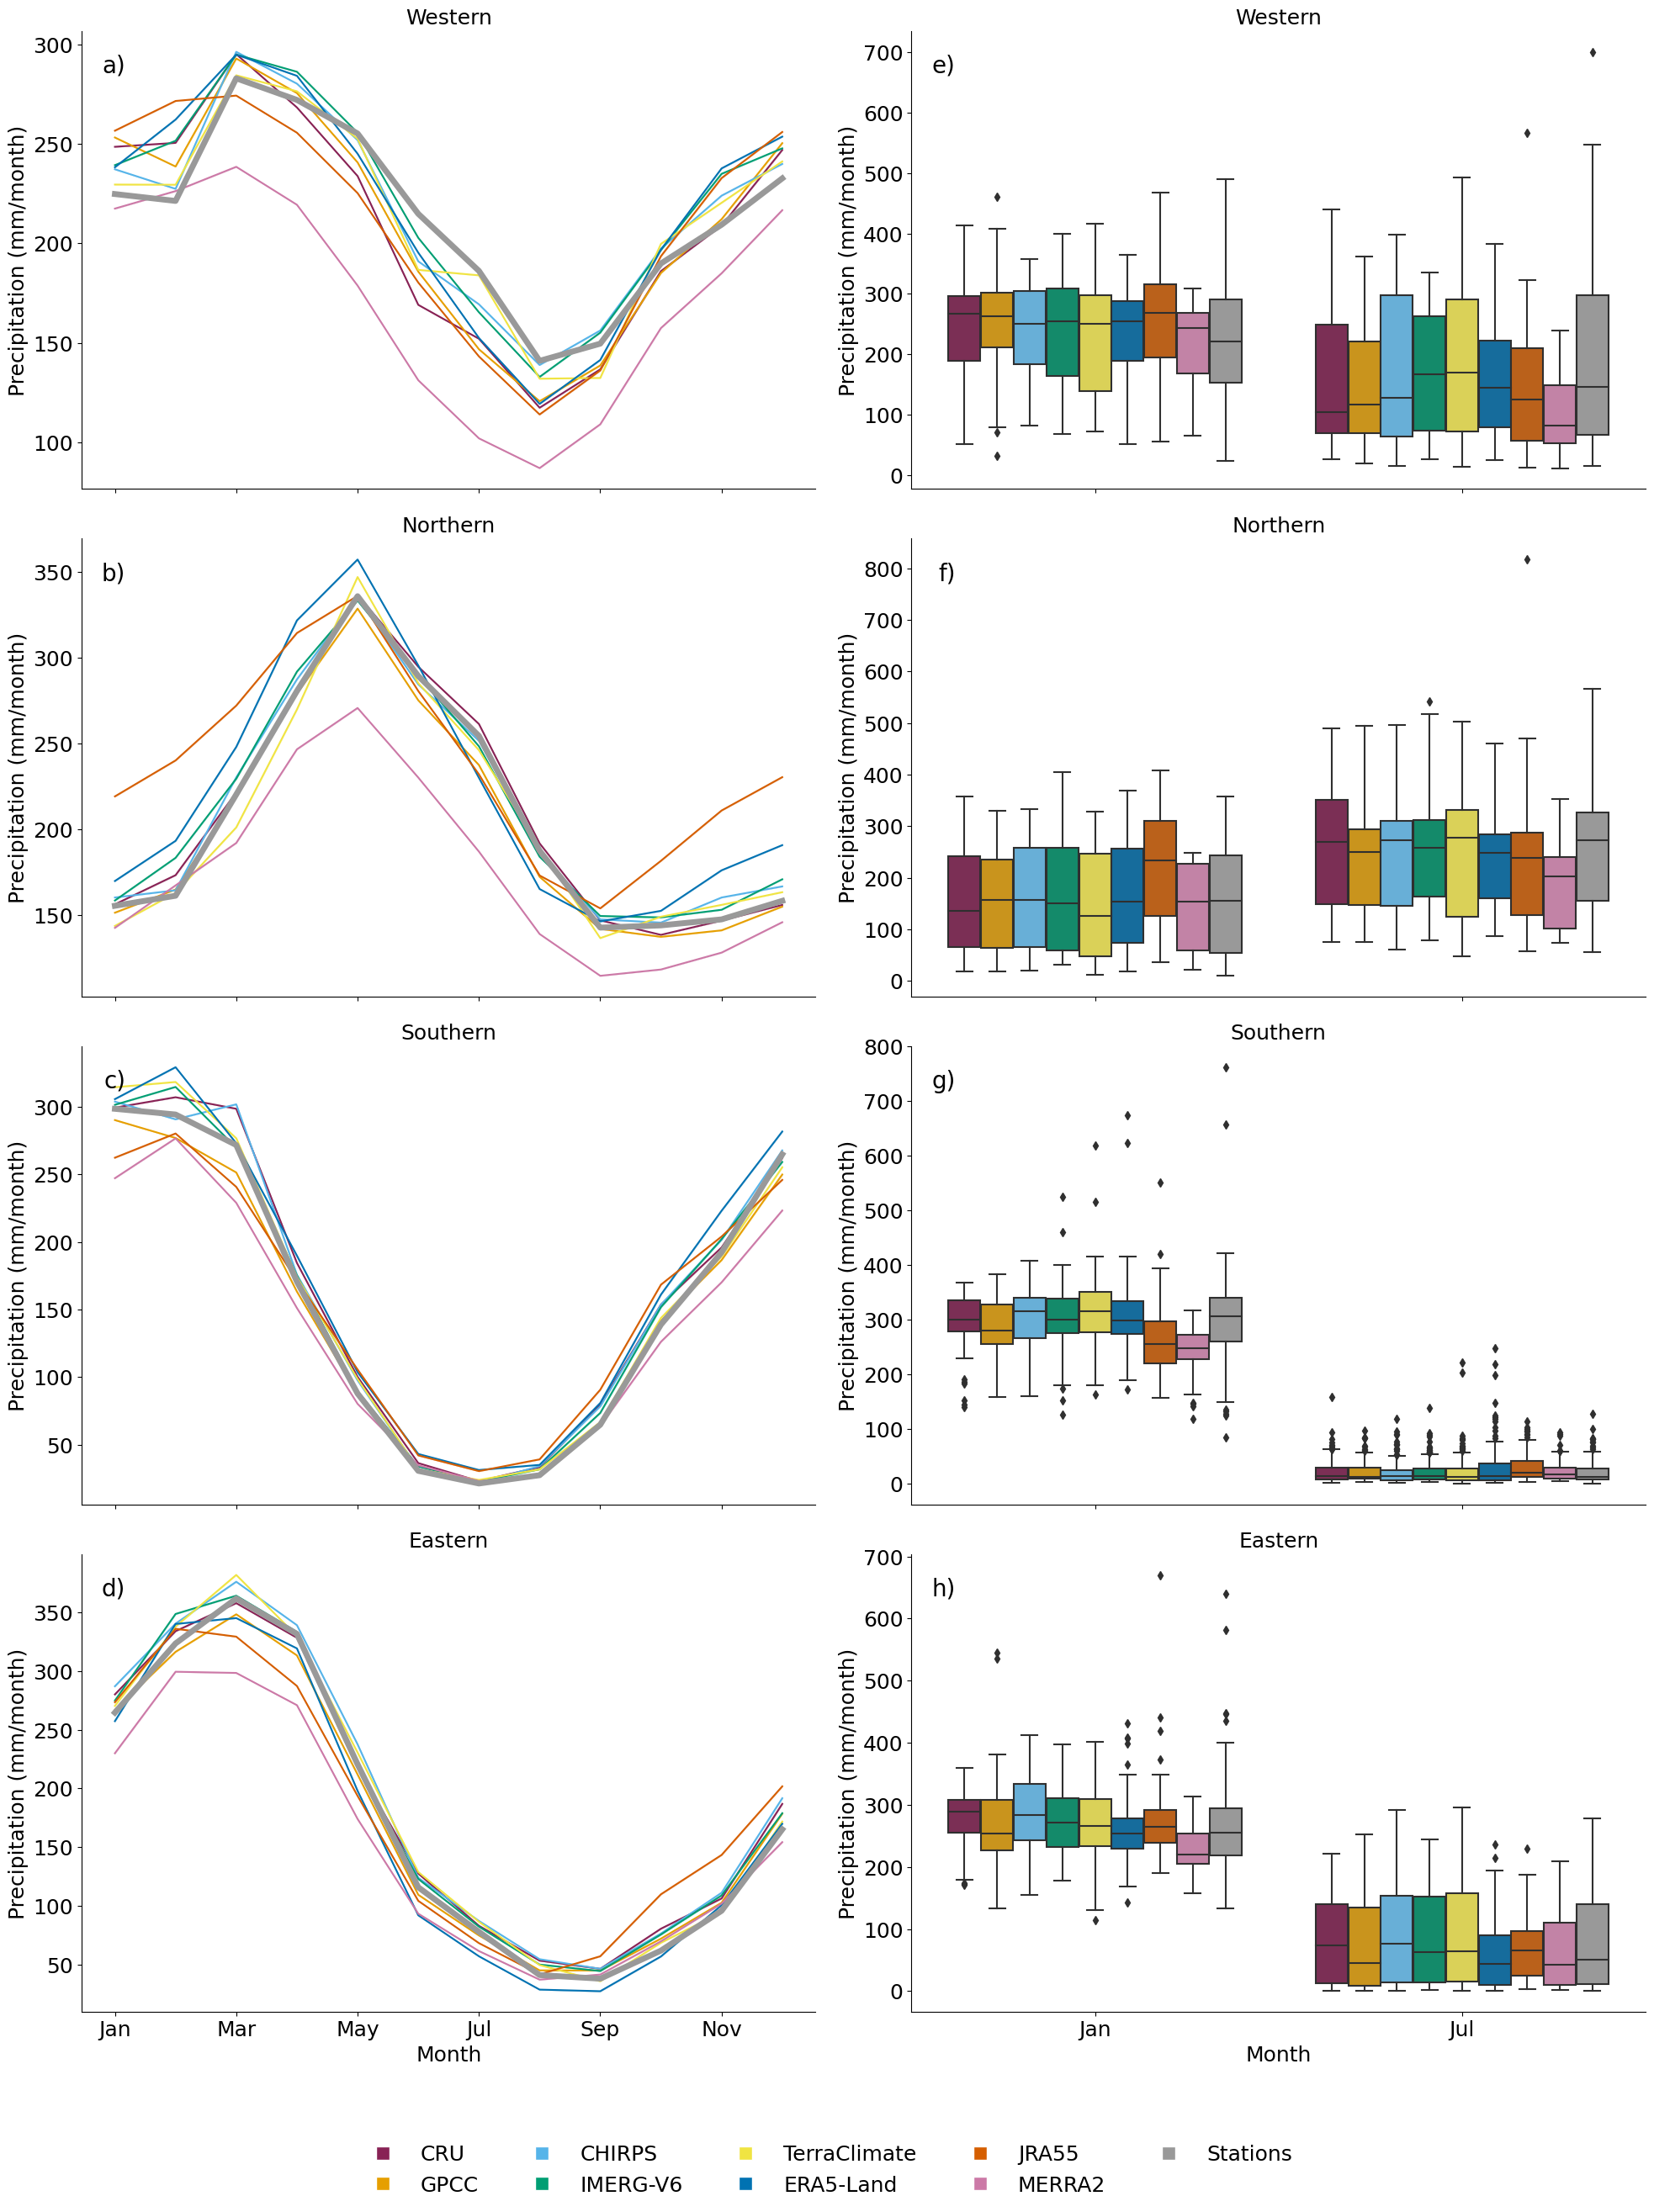

In [14]:
#df_plot = df[df.season.isin(['DJF', 'JJA'])]
#a lineplot for each region
fig, axes = plt.subplots(4,2, figsize=(20, 25), sharex='col')
plt.rcParams.update({'font.size': 18})
letters_ts = ['a)', 'b)', 'c)', 'd)']
letters_pdf = ['e)', 'f)', 'g)', 'h)']
df_plot = df[df.month.isin([1,7])]
for i, region in enumerate(regions_list):
    sns.lineplot(data=df[df.Region==region], x='month', y='pr', hue='Dataset', ax=axes[i,0], palette=wong, hue_order=hue_order, legend=False, errorbar=('sd',0))
    sns.lineplot(data=df[(df.Region==region) & (df.Dataset=='Stations')], x='month', y='pr', hue='Dataset', ax=axes[i,0], palette=['#999999'], legend=False,zorder=100, errorbar=('sd',0), linewidth=5)
    sns.boxplot(data=df_plot[df_plot.Region==region], x='month', y='pr', hue='Dataset', ax=axes[i,1], palette=wong, hue_order=hue_order)
    axes[i,0].set_title(region, fontsize=18)
    axes[i,1].set_title(region, fontsize=18)
    axes[i,0].set_ylabel('Precipitation (mm/month)', fontsize=18)
    axes[i,1].set_ylabel('Precipitation (mm/month)', fontsize=18)
    axes[i,0].set_xlabel('', fontsize=18)
    axes[i,1].set_xlabel('', fontsize=18)
    axes[3,0].set_xlabel('Month', fontsize=18)
    axes[3,1].set_xlabel('Month', fontsize=18)
    #axes[i,0].get_legend().remove()
    axes[i,1].get_legend().remove()
    axes[i,0].text(0.06,0.95, letters_ts[i], transform=axes[i,0].transAxes, size=20, va='top', ha='right')
    axes[i,1].text(0.06,0.95, letters_pdf[i], transform=axes[i,1].transAxes, size=20, va='top', ha='right')
    #change ticks from 1 7 to Jan Jul
    #axes[i,0].set_xticks([1,7])
    axes[i,1].set_xticklabels(['Jan', 'Jul'])
    axes[i,0].set_xticks([1,3,5,7,9,11])
    axes[i,0].set_xticklabels(['Jan', 'Mar', 'May', 'Jul', 'Sep', 'Nov'])
    #despine
    sns.despine()
    


fig.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.06), loc='lower center', ncol=5, frameon=False, fontsize=18)

#put legend outside the plot
plt.tight_layout()

# pdf

In [21]:
ds_dict = {}
for i, dataset in enumerate(datasets):
    ds = xr.open_dataset(os.path.join(folder_ts, dataset + '.nc'))
    mask = regions_mask.mask(ds, lon_name='lon', lat_name='lat')
    ds = ds.sel(time=(ds['time.month'] == 1) | (ds['time.month'] == 7))
    ds['Region'] = mask
    #only jan and july data
    ds_dict[datasets_names[i]] = ds

c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry
c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry


In [22]:
stations = gpd.read_file(r'Data\Evaluation\stations_amz_ANA.geojson')
df_stat= pd.read_pickle(r'Data\Evaluation\amz_01_20_20bet.pkl')
df_stat['month'] = df_stat['Date'].dt.month
df_stat['year'] = df_stat['Date'].dt.year
#just months 1 or 7
df_month = df_stat[(df_stat['month']==1) | (df_stat['month']==7)]
df_month = df_month.merge(stations[['Code','Region', 'geometry']], on='Code').drop(['Code', 'Date'], axis=1)
df_month.rename(columns={'Total':'pr'}, inplace=True)

data = df_month[['geometry', 'year', 'month','pr']].copy()
data['lon'] = data['geometry'].apply(lambda p: p.x)
data['lat'] = data['geometry'].apply(lambda p: p.y)
data = data.drop(columns=['geometry'])
var = 'pr'

In [23]:
pixel_dict = {}
for i , name in enumerate(datasets_names):
    ds = ds_dict[name].copy()
    
    # Step 2: Assign each point to the grid cells of the 'ds' DataArray
    ds_grid_lon, ds_grid_lat = ds.lon.values, ds.lat.values
    data['lon_bin'] = np.digitize(data['lon'], ds_grid_lon)
    data['lat_bin'] = np.digitize(data['lat'], ds_grid_lat)
    # Step 3: Compute the mean rainfall value for each grid cell and each year
    grid_cells = data.groupby(['year', 'lat_bin', 'lon_bin','month'])['pr'].mean().reset_index()
    # Step 4: Create an empty DataArray with NaN values
    empty_grid = np.full((2,len(data['year'].unique()), len(ds_grid_lat), len(ds_grid_lon)), np.nan)
    # Step 5: Fill the DataArray with the computed mean rainfall values for each year
    for _, row in grid_cells.iterrows():
        month_idx = np.where(data['month'].unique() == row['month'])[0][0]
        year_idx = np.where(data['year'].unique() == row['year'])[0][0]
        lat_idx, lon_idx = row['lat_bin'], row['lon_bin']
        #idx to int
        lat_idx, lon_idx = int(lat_idx), int(lon_idx)
        empty_grid[month_idx, year_idx, lat_idx - 1, lon_idx - 1] = row['pr']
    # Step 6: Create an xarray DataArray from the result with the year dimension
    month_coords = data['month'].unique()
    year_coords = data['year'].unique()
    data_array = xr.DataArray(empty_grid,
                                dims=('month','year', 'lat', 'lon'),
                                coords={'month':month_coords,'year': year_coords, 'lat': ds_grid_lat, 'lon': ds_grid_lon})
    
    # Now you have an xarray DataArray 'data_array' with the grid of 'ds', mean rainfall values for each cell,
    # and the year dimension representing the yearseries.

    # Now you have an xarray DataArray 'data_array' with the grid of 'ds', mean rainfall values for each cell,
    data_array = data_array.to_dataset(name=var)
    data_array['Region'] = ds['Region']
    pixel_dict[name] = ds.where(data_array.isel(month=0, year=0).pr >= 0)

In [24]:
df = pd.DataFrame()
for name in datasets_names:
    dff =  ds_dict[name].sel(time=pixel_dict[name].time.dt.month.isin([1,7])).to_dataframe().dropna().reset_index()
    dff['Dataset'] = name
    df = df.append(dff)

df['time'] = df.time.astype(str)
#from time column to datetime with date and hour
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d')
df['month'] = df['time'].dt.month
df = df[['month','pr', 'Region', 'Dataset']]
df['Region'] = df['Region'].replace(regions_replace)

stations = gpd.read_file(r'Data\Evaluation\stations_amz_ANA.geojson')
df_stat= pd.read_pickle(r'Data\Evaluation\amz_01_20_20bet.pkl')
df_stat['month'] = df_stat['Date'].dt.month
#just months 1 or 7
df_month = df_stat[(df_stat['month']==1) | (df_stat['month']==7)]
df_month = df_month.merge(stations[['Code','Region']], on='Code').drop(['Code', 'Date'], axis=1)
df_month.rename(columns={'Total':'pr'}, inplace=True)
df_month['Dataset'] = 'Stations'
df = df.append(df_month)

C:\Users\luisg\AppData\Local\Temp\ipykernel_22684\2034231162.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_22684\2034231162.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_22684\2034231162.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_22684\2034231162.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_22684\2034231162.py:5: FutureWarning: The frame.append method is dep

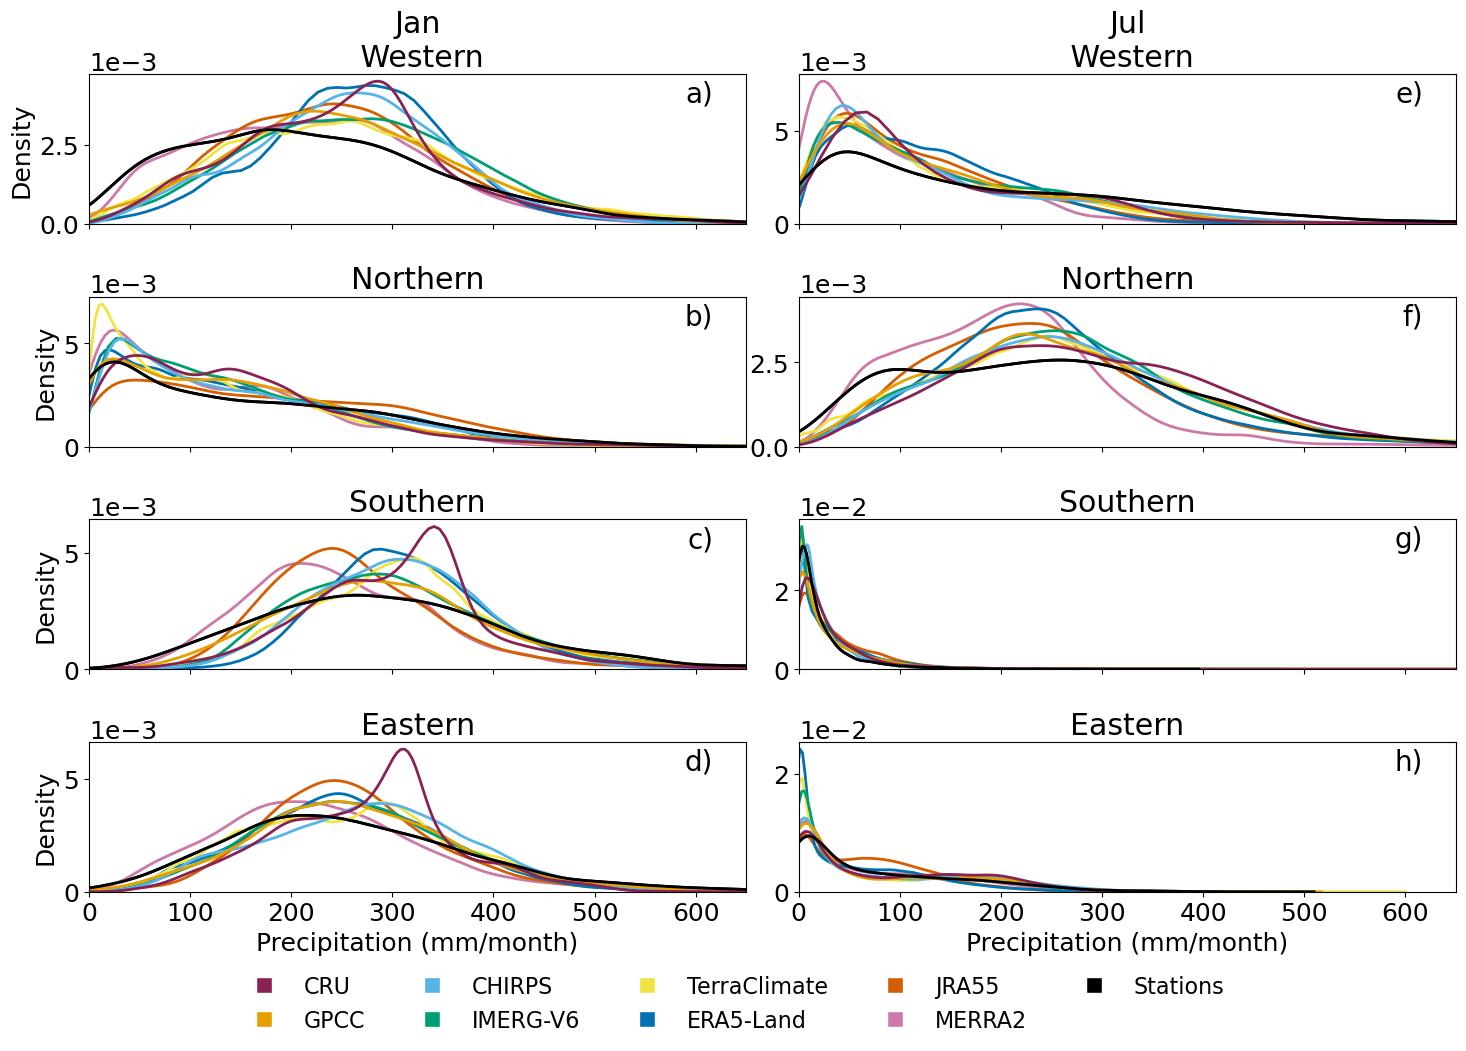

In [25]:
fig, axs = plt.subplots(4, 2, figsize=(15, 10), sharex='col')
month_l = ['Jan', 'Jul']
letters_ts = ['a)', 'b)', 'c)', 'd)']
letters_pdf = ['e)', 'f)', 'g)', 'h)']
for i, region in enumerate(regions_list):
    df_reg = df[df.Region==region]
    for j, month in enumerate([1,7]):
        df_reg_month = df_reg[df_reg.month==month]
        sns.kdeplot(data=df_reg_month, ax=axs[i, j], x='pr', hue='Dataset', fill=False, common_norm=False, linewidth=2,palette=wong_b, hue_order=hue_order, legend=False)
        sns.kdeplot(data=df_reg_month[df_reg_month.Dataset=='Stations'], x='pr', fill=False,linewidth=2,color='black', zorder=100,ax=axs[i, j], legend=False)
        axs[i, j].set_title('')
        axs[i, j].set_xlabel('Precipitation (mm/month)')
        axs[i, j].set_xlim(0, 650)
        axs[i, j].set_title(region)
        axs[i, j].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        if i == 0:
            axs[i, j].set_title(month_l[j] + '\n Western' )
        
    axs[i, 1].set_ylabel('')
    axs[i, 0].set_ylabel('Density')
    axs[i, 0].text(0.95,0.96,  letters_ts[i], transform=axs[i, 0].transAxes,  fontsize=20, va='top', ha='right')
    axs[i, 1].text(0.95,0.96,  letters_pdf[i], transform=axs[i, 1].transAxes,  fontsize=20, va='top', ha='right')   

fig.legend(handles=legend_elements_b, bbox_to_anchor=(0.5, -0.07), loc='lower center', ncol=5, frameon=False, fontsize=16)
plt.tight_layout()

# taylor

In [26]:
from Data.utils.taylor import *
from scipy.stats import pearsonr
df = pd.DataFrame()
for name in datasets_names:
    dff =  pixel_dict[name].sel(time=ds_dict[name].time.dt.month.isin([1,7])).to_dataframe().dropna().reset_index()
    dff['Dataset'] = name
    df = df.append(dff)

df['time'] = df.time.astype(str)
#from time column to datetime with date and hour
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d')
df = df[['time','pr', 'Region', 'Dataset']]
df['Region'] = df['Region'].replace({ 0:'Southern', 1:'Eastern',2:'Western', 3:'Northern'})
stations = gpd.read_file(r'Data\Evaluation\stations_amz_ANA.geojson')
df_stat= pd.read_pickle(r'Data\Evaluation\amz_01_20_20bet.pkl')
df_stat['month'] = df_stat['Date'].dt.month
#just months 1 or 7
df_month = df_stat[(df_stat['month']==1) | (df_stat['month']==7)]
df_month = df_month.merge(stations[['Code','Region']], on='Code').drop(['Code', 'month'], axis=1)
#df_stat = df_stat.groupby(['Region','Date']).mean().reset_index().drop('Code', axis=1)
df_month.rename(columns={'Date':'time', 'Total':'pr'}, inplace=True)
df_month['Dataset'] = 'Stations'
df = df.append(df_month)
df_mean = df.groupby(['time','Region', 'Dataset']).mean().reset_index()
df_mean['month'] = df_mean['time'].dt.month

C:\Users\luisg\AppData\Local\Temp\ipykernel_22684\3194309962.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_22684\3194309962.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_22684\3194309962.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_22684\3194309962.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_22684\3194309962.py:7: FutureWarning: The frame.append method is dep

In [27]:
#for each dataset and each region, do the pearson r with stations
df_corr = pd.DataFrame()
std_ref = []

for k, month in enumerate([1,7]):
    df_sea = df_mean[df_mean['month'] == month]
    for region in ['Western', 'Northern', 'Southern', 'Eastern']:
        df_region = df_sea[df_sea['Region'] == region]
        df_station = df_region[df_region['Dataset'] == 'Stations']
        for dataset in datasets_names:
            df_ds = df_region[df_region['Dataset'] == dataset]
            # do correlation
            corr = pearsonr(df_ds.pr.values, df_station.pr.values)[0].round(2)
            df_corr = df_corr.append({'Region': region, 'Dataset': dataset, 'corr': corr, 'sd':df_ds.pr.values.std()/df_station.pr.values.std(), 'month':month}, ignore_index=True)
            std_ref.append(df_station.pr.values.std())

C:\Users\luisg\AppData\Local\Temp\ipykernel_22684\1449152379.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr = df_corr.append({'Region': region, 'Dataset': dataset, 'corr': corr, 'sd':df_ds.pr.values.std()/df_station.pr.values.std(), 'month':month}, ignore_index=True)
C:\Users\luisg\AppData\Local\Temp\ipykernel_22684\1449152379.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr = df_corr.append({'Region': region, 'Dataset': dataset, 'corr': corr, 'sd':df_ds.pr.values.std()/df_station.pr.values.std(), 'month':month}, ignore_index=True)
C:\Users\luisg\AppData\Local\Temp\ipykernel_22684\1449152379.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr = df_corr.append({'Region': region, 'Dataset': 

In [28]:
marker_list = ['*','.' ]
marker_legend = [Line2D([0], [0],  marker='*', color='w', label='JAN', markerfacecolor='black', markersize=12),
                  Line2D([0], [0],  marker='.', color='w', label='JUL', markerfacecolor='black', markersize=12)]
marker_legend = marker_legend +  legend_elements_b


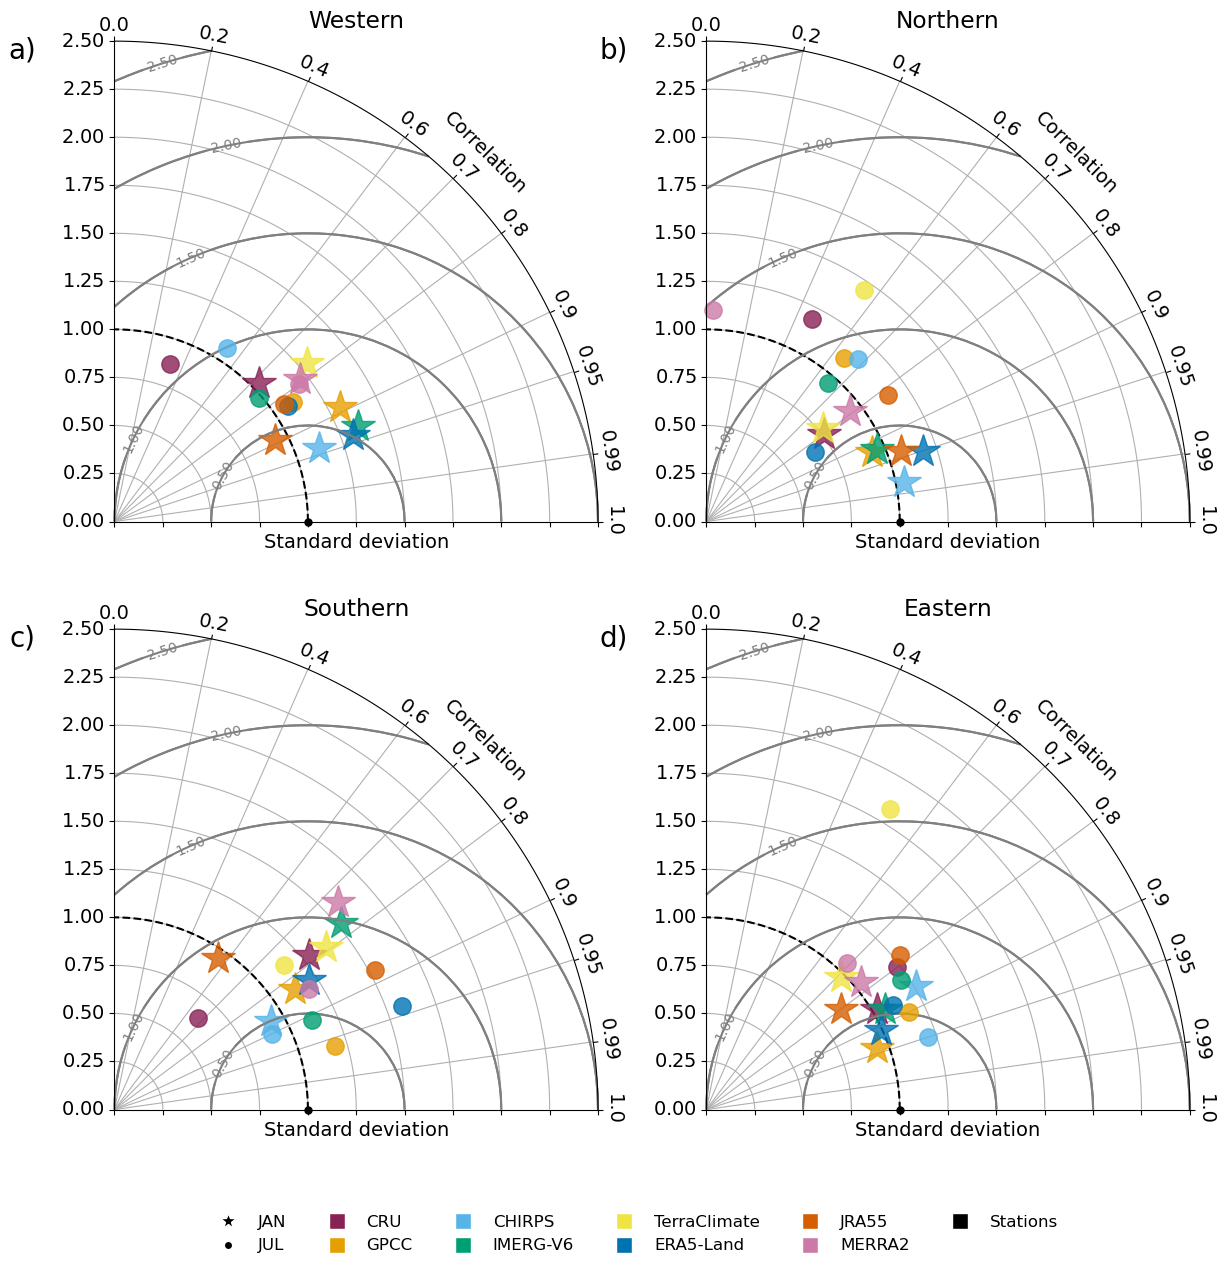

In [29]:
# Create a figure and a gridspec layout
fig = plt.figure(figsize=(14, 14))
plt.rcParams.update({'font.size': 14})
mss = 25
for i, region in enumerate(['Western', 'Northern', 'Southern', 'Eastern']):
    dia = TaylorDiagram(1, fig=fig, label='Stations', extend=False, rect=int('22'+str(i+1)),srange=(0, 2.5))

# Create a figure and a gridspec layout
    for k, month in enumerate([1,7]):
        df_corr_sea = df_corr[df_corr['month'] == month]

        df_reg = df_corr_sea[df_corr_sea.Region == region]
        # Add samples to Taylor diagram
        contours = dia.add_contours(colors='0.5')
        for j, name in enumerate(datasets_names):
            df_set = df_reg[df_reg['Dataset'] == name]
            std = df_set['sd'].values[0]
            corr = df_set['corr'].values[0]
            dia.add_sample(std, corr, marker=marker_list[k], ms=mss, ls='', mfc=wong_b[j], mec=wong_b[j], label=name, alpha=0.8)

    
    dia.add_grid()                                  # Add grid
    dia._ax.axis[:].major_ticks.set_tick_out(True)
    dia._ax.axis['left'].toggle(ticklabels=False)
    dia._ax.axis['left'].label.set_text("Standard deviation")
    dia._ax.set_title(region) 
    dia._ax.text(-0.15,1,  letters_ts[i], transform=dia._ax.transAxes,  fontsize=20, va='top', ha='right')    

    # Put ticks outward
#legend in the middle outside of the plot
    plt.clabel(contours, inline=1, fontsize=10, fmt='%.2f')

fig.legend(handles=marker_legend, bbox_to_anchor=(0.5, 0), loc='lower center', ncol=6, frameon=False, fontsize=12)
#legend in the middle outside of the plot
#plt.tight_layout()

# lag

In [30]:
folder_ts = r'Data\Datasets\amz\ts'


In [31]:
dsds_dict = {}
for i, dataset in enumerate(datasets):
    ds = xr.open_dataset(os.path.join(folder_ts, dataset + '.nc'))
    mask = regions_mask.mask(ds, lon_name='lon', lat_name='lat')

    ds['region'] = mask
    ds = ds.groupby('region').mean()
    ds_dict[datasets_names[i]] = ds

c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry
c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry


In [32]:
df = pd.DataFrame()
for name in datasets_names:
    dff =  ds_dict[name].to_dataframe().dropna().reset_index()
    dff['dataset'] = name
    df = df.append(dff)
df = df[['time','pr', 'region', 'dataset']]
df['region'] = df['region'].replace({0:'West', 1:'North', 2:'South', 3:'East'})
df['time'] = df.time.astype(str)
#from time column to datetime with date and hour
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d').dt.strftime('%Y-%m-%d')
#time to Date rename
df = df.rename(columns={'time':'Date'})
stations = gpd.read_file(r'Data\Evaluation\stations_amz_ANA.geojson')
df_stat= pd.read_pickle(r'Data\Evaluation\amz_01_20_20bet.pkl')
df_stat = df_stat.merge(stations[['Code','Region']], on='Code')
df_stat =  df_stat.groupby(['Region','Date']).mean().reset_index().drop('Code', axis=1).rename(columns={'Total':'pr', 'Region':'region'})
df_stat['dataset'] = 'Stations'
df = df.append(df_stat)
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d').dt.strftime('%Y-%m-%d')

C:\Users\luisg\AppData\Local\Temp\ipykernel_22684\3167796886.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_22684\3167796886.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_22684\3167796886.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_22684\3167796886.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_22684\3167796886.py:5: FutureWarning: The frame.append method is dep

In [33]:
#import pearsonr
from scipy.stats import pearsonr
# Time lagged cross correlation
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 

    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    datax = datax.reset_index().pr
    datay = datay.reset_index().pr
    return datax.corr(datay.shift(lag))

In [34]:
df_west = df[df['region']=='West']
#d1 as df_west dataset CRU
d1 = df_west[df_west['dataset']=='CRU']
#d2 as df_west dataset Stations
d2 = df_west[df_west['dataset']=='Stations']

In [35]:
# lags = np.arange(-(fs), (fs), 1)  # uncontrained
lags = np.arange(0, (12), 1)  # contrained
rs = np.nan_to_num([crosscorr(d1, d2, lag) for lag in lags])
lag_max = lags[np.argmax(rs)]

In [36]:
df_lag = pd.DataFrame()
for i, region in enumerate(['West', 'North', 'South', 'East']):
    df_region = df[df['region'] == region]
    df_stat = df_region[df_region['dataset'] == 'Stations']
    for j, name in enumerate(datasets_names):
        dff = df_region[df_region['dataset'] == name]
        rs = np.nan_to_num([crosscorr(dff, df_stat, lag) for lag in lags])
        lag_max = lags[np.argmax(rs)]
        df_lag = df_lag.append({'region': region, 'dataset': name, 'lag': lag_max}, ignore_index=True)
        

C:\Users\luisg\AppData\Local\Temp\ipykernel_22684\545435079.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_lag = df_lag.append({'region': region, 'dataset': name, 'lag': lag_max}, ignore_index=True)
C:\Users\luisg\AppData\Local\Temp\ipykernel_22684\545435079.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_lag = df_lag.append({'region': region, 'dataset': name, 'lag': lag_max}, ignore_index=True)
C:\Users\luisg\AppData\Local\Temp\ipykernel_22684\545435079.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_lag = df_lag.append({'region': region, 'dataset': name, 'lag': lag_max}, ignore_index=True)
C:\Users\luisg\AppData\Local\Temp\ipykernel_22684\545435079.py:9: FutureWarning: The frame.append method is depr

# Julia

In [37]:
#open excel with pandas
import pandas as pd
df_points = pd.read_excel(r"D:\GU\IC\model\CWM_values_to_Marina.xlsx")

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\GU\\IC\\model\\CWM_values_to_Marina.xlsx'

In [ ]:
#create a df with all ds in ds_dict
df = pd.DataFrame()
for name in datasets_names:
    dss=  ds_dict[name]
    for j in range(8):
        dff_point = df_points.iloc[j]
        lat = dff_point['LatitudeDecimal']
        lon = dff_point['LongitudeDecimal']
        df_point = dss.sel(lat=lat, lon=lon, method='nearest').to_dataframe().dropna().reset_index()
        df_point['Dataset'] = name
        df_point['Point'] = dff_point['Site']
        df = df.append(df_point)
df = df[['month','pr', 'Region', 'Dataset', 'Point']]


C:\Users\luisg\AppData\Local\Temp\ipykernel_3096\2901841324.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_point)
C:\Users\luisg\AppData\Local\Temp\ipykernel_3096\2901841324.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_point)
C:\Users\luisg\AppData\Local\Temp\ipykernel_3096\2901841324.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_point)
C:\Users\luisg\AppData\Local\Temp\ipykernel_3096\2901841324.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_point)
C:\Users\luisg\AppData\Local\Temp\ipykernel_3096\2901841324.py:12: FutureWarning: The frame.

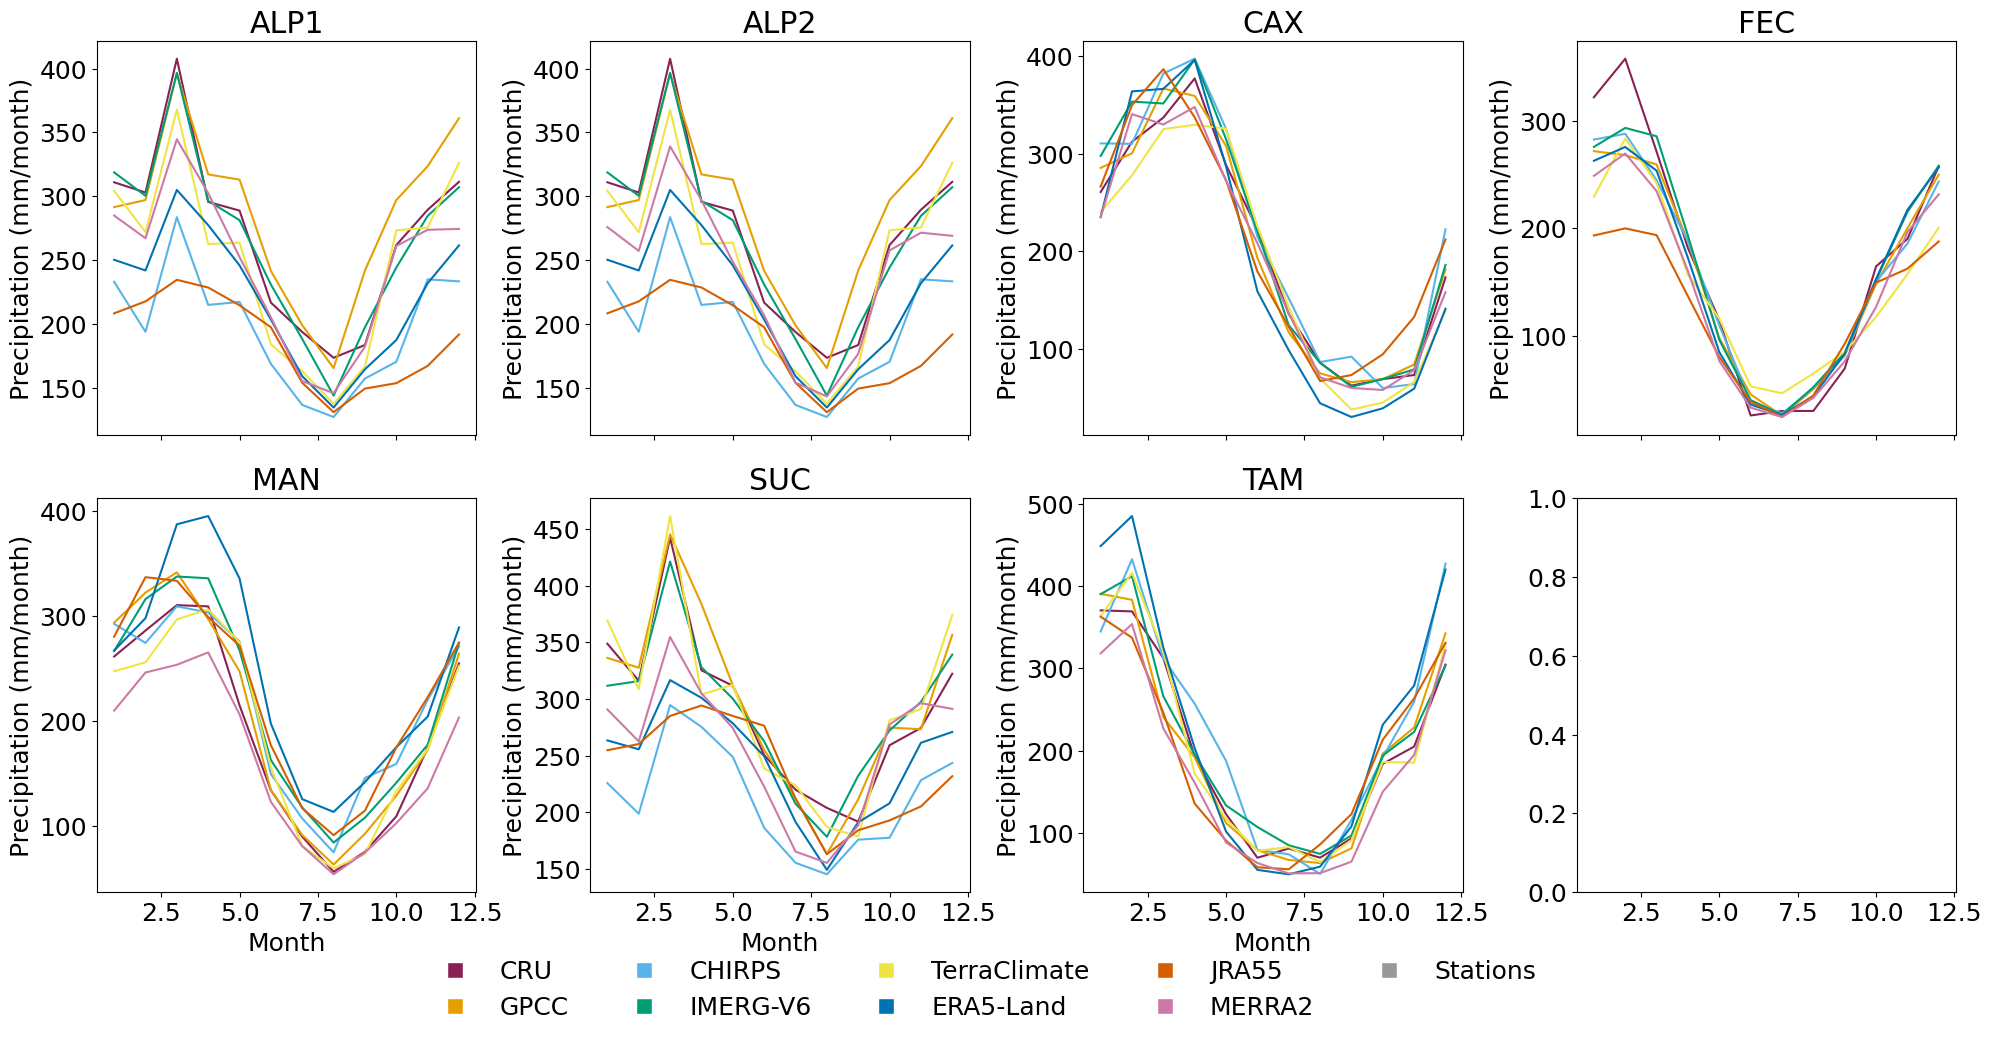

In [ ]:
#plot lineplot of each point
fig, axes = plt.subplots(2,4, figsize=(20, 10), sharex='col')
plt.rcParams.update({'font.size': 18})
axes = axes.flatten()
for j, point in enumerate(df.Point.unique()):
    ax = axes[j]
    sns.lineplot(data=df[df.Point==point], x='month', y='pr', hue='Dataset', ax=ax, palette=wong, hue_order=hue_order, legend=False)
    ax.set_title(point)
    ax.set_xlabel('Month')
    ax.set_ylabel('Precipitation (mm/month)')

fig.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.06), loc='lower center', ncol=5, frameon=False, fontsize=18)

plt.tight_layout()

# test pdfs


In [ ]:
datasets_names_stat = datasets_names.copy()
datasets_names_stat.append('Stations')
import scipy.stats as stats

ndatasets=len(datasets_names)+1
#bins for histograms
bins=20*np.arange(40)
#What is going on here?  Test!
#bin_centers=bins[0:-1]+np.diff(bins)/2.
nbins=len(bins)
#need to subtract 1 from nbins because bins are the edges
#and are 1 more value than the histogram
df_gamma = pd.DataFrame()
for k, month in enumerate([1,7]):
    df_month = df[df.month==month]
    for i, name in enumerate(datasets_names_stat):
        data = df_month[df_month.Dataset==name]
        for j, region in enumerate(regions_list):
            data_region = data[data.Region==region].pr.values
            fit_alpha, fit_loc, fit_beta = stats.gamma.fit(data_region)
            vall = stats.gamma.pdf(bins, fit_alpha, fit_loc, fit_beta)
            dff = pd.DataFrame( {'Dataset': name, 'Bin': bins, 'Region': region, 'Value': vall, 'month': month})
             = df_gamma.append(dff, ignore_index=True)
df_gamma
fig, axs = plt.subplots(4, 2, figsize=(15, 10), sharex='col')
for i, region in enumerate(regions_list):
    df_reg = df_gamma[df_gamma.Region==region]
    for j, month in enumerate([1,7]):
        df_reg_month = df_reg[df_reg.Month==month]
        sns.lineplot(data=df_reg_month, ax=axs[i, j], x='Bin',y='Value', hue='Dataset', palette=wong_b, hue_order=hue_order, legend=False)
        sns.lineplot(data=df_reg_month[df_reg_month.Dataset=='Stations'],x=bins, y='Value', color='black', zorder=100,ax=axs[i, j], legend=False)
        axs[i, j].set_title('')
        axs[i, j].set_xlabel('Precipitation (mm/month)')
        axs[i, j].set_xlim(0, 650)
        if i == 0:
            axs[i, j].set_title(month)
    axs[i, 1].set_ylabel('')
    axs[i, 0].set_ylabel(region)


fig.legend(handles=legend_elements_b, bbox_to_anchor=(0.5, -0.06), loc='lower center', ncol=5, frameon=False, fontsize=16)

plt.tight_layout()
fig, axes = plt.subplots(2,2, figsize=(10,10))
axes = axes.flatten()
for i, region in enumerate(['West', 'North', 'South', 'East']):
    for j, name in enumerate(datasets_names):
        axes[i].plot(bin_centers, histogram_datasets[:,j,i], label=name)
    axes[i].plot(bin_centers, histogram_datasets[:,-1,i], label='Stations')
    axes[i].set_title(region)
    axes[i].set_ylabel('Probability Density')
    axes[i].set_xlabel('MAP (mm)')
    axes[i].legend(loc='upper right')


plt.tight_layout()